*数据预处理*

In [1]:
import pandas as pd
import numpy as np
import warnings
from itertools import combinations

# 忽略一些警告，保持输出整洁
warnings.filterwarnings('ignore')

# 1. 读取数据
file_path = 'cleaned_final_dataset2_2000_2010.parquet'
df = pd.read_parquet(file_path, engine='fastparquet')

selected_vars = [col for col in df.columns if col not in ['ts_code', 'year', 'month', 'next_ret']]
column_order = ['ts_code', 'year', 'month', 'next_ret'] + selected_vars

# 2. 直接重新排列
df = df[column_order]


In [2]:
df = df.rename(columns={'ts_code': 'stkcd'})

# 【关键修正】：先将年份和月份转换为整数 (int)，去掉 .0
# 这一步是为了防止出现 "2001.0-1.0-01" 这种错误格式
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df = df.drop(columns=['date', 'next_ret'], errors='ignore')

# 2. 构造时间索引
print("正在构造时间索引...")
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# ================= 修改开始 =================

# 步骤 A: 严格排序
# 必须先按 股票代码 和 日期 排序，否则 shift 会乱
df = df.sort_values(['stkcd', 'date']).reset_index(drop=True)

ret_col = 'ret' 

# 步骤 B: 构造“理论上的下个月日期”
# 使用 DateOffset 自动处理跨年问题（例如 12月+1个月 = 次年1月）
df['expected_next_date'] = df['date'] + pd.DateOffset(months=1)

# 步骤 C: 获取物理位置上的“下一行”数据
# 这一步和原来一样，先把下一行的数据拉上来
df['next_ret_raw'] = df.groupby('stkcd')[ret_col].shift(-1)
df['next_date_raw'] = df.groupby('stkcd')['date'].shift(-1)

# 步骤 D: 【核心修复】校验日期是否匹配
# 如果 "下一行的日期" == "理论上的下个月"，说明数据连续，保留收益率
# 否则，说明中间有停牌或断层，置为 NaN
import numpy as np
df['next_ret'] = np.where(
    df['next_date_raw'] == df['expected_next_date'], 
    df['next_ret_raw'], 
    np.nan
)

# 步骤 E: 清理中间变量，节省内存
df = df.drop(columns=['expected_next_date', 'next_ret_raw', 'next_date_raw'])
# ================= 修改结束 =================

df = df.dropna(subset=['next_ret']).copy()

df = df.sort_values(['date', 'stkcd']).reset_index(drop=True)

# 【新增】备份原始市值，用于后续加权
df['raw_size'] = df['size'] 

# 更新特征列表
feature_cols = [col for col in df.columns if col not in ['stkcd', 'year', 'month', 'ret', 'date', 'next_ret', 'raw_size']]
print(f"特征工程完成。总特征数量: {len(feature_cols)}")


# 6. 特征标准化：Rank Normalization (映射到 [-1, 1])
print("正在进行截面标准化...")
def rank_normalize(x):
    return (x.rank() - 1) / (x.count() - 1) * 2 - 1

df[feature_cols] = df.groupby('date')[feature_cols].transform(rank_normalize)
df[feature_cols] = df[feature_cols].fillna(0)

print("第一步完成：数据准备就绪。")
df


正在构造时间索引...
特征工程完成。总特征数量: 91
正在进行截面标准化...
第一步完成：数据准备就绪。


,stkcd,year,month,ret,size,Bm,Ep,OCFtoNI,APTurnover,APDays,...,RVI,DividendYield,RVI_Strength,RankMomentum_6_1,RVI_Cross,RVI_Volume,Roe,date,next_ret,raw_size
0,000001.SZ,2000,1,NaN,0.993620,-0.472843,0.000000,0.0,0.000000,0.000000,...,0.253205,0.517949,1.000000,0.000000,0.760766,0.000000,0.000000,2000-01-01,-0.009730,2.870917e+06
1,000002.SZ,2000,1,NaN,0.620415,0.667732,0.000000,0.0,0.000000,0.000000,...,0.060897,-0.641026,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.405687,5.755420e+05
2,000003.SZ,2000,1,NaN,-0.837321,0.246006,0.000000,0.0,0.000000,0.000000,...,-0.266026,0.000000,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.147826,1.917243e+05
3,000005.SZ,2000,1,NaN,0.377990,0.175719,0.000000,0.0,0.000000,0.000000,...,0.009615,0.000000,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.040000,4.273644e+05
4,000006.SZ,2000,1,NaN,-0.231260,0.795527,0.000000,0.0,0.000000,0.000000,...,0.509615,0.210256,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.049136,2.786972e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118281,601988.SH,2010,11,-0.050428,0.995468,0.947050,0.983099,0.0,0.000000,0.000000,...,0.012140,0.980075,0.221299,-0.913836,0.219789,-0.017372,0.523989,2010-11-01,-0.012232,8.879526e+07
118282,601989.SH,2010,11,0.067127,0.910876,0.481089,0.000000,0.0,0.000000,0.000000,...,0.177542,-0.342466,-0.750755,0.963546,-0.734894,-0.017372,0.000000,2010-11-01,0.090657,7.189731e+06
118283,601991.SH,2010,11,-0.084605,0.930514,0.629349,0.169953,0.0,-0.802567,0.806515,...,-0.673748,0.529265,0.221299,-0.985087,0.219789,-0.017372,-0.403575,2010-11-01,-0.077273,8.124625e+06
118284,601998.SH,2010,11,-0.049037,0.983384,0.862330,0.962441,0.0,0.000000,0.000000,...,0.518968,0.773350,0.221299,-0.907208,0.219789,-0.017372,0.572907,2010-11-01,-0.033149,2.119511e+07


In [3]:
# ==========================================
# 修改后的 Step 2: 滚动预测 (加入 size 保存)
# ==========================================
from sklearn.ensemble import RandomForestRegressor

# 1. 设定参数
train_window_months = 24
unique_dates = sorted(df['date'].unique())

predictions = []
feature_importances = []

print(f"开始滚动预测... 总共有 {len(unique_dates)} 个月的数据。")

# 2. 滚动循环
for i in range(train_window_months, len(unique_dates)):
    predict_date = unique_dates[i]
    start_date = unique_dates[i - train_window_months]
    
    # 切分训练集和测试集
    train_mask = (df['date'] >= start_date) & (df['date'] < predict_date)
    test_mask = (df['date'] == predict_date)
    
    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, 'next_ret']
    
    X_test = df.loc[test_mask, feature_cols]
    
    if len(X_train) == 0 or len(X_test) == 0:
        continue
        
    # 3. 模型训练 (建议参数稍微加强一点)
    model = RandomForestRegressor(
        n_estimators=100,     # 增加树的数量
        max_depth=6,          # 稍微加深深度
        min_samples_leaf=20,  
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # 4. 预测
    pred_y = model.predict(X_test)
    
    # 5. 存储结果 (【关键修改】：这里增加了 'size' 字段)
    # 注意：确保你的 df 中有 'size' 这一列（我们在特征工程里用到了，应该还在）
    temp_res = df.loc[test_mask, ['date', 'stkcd', 'next_ret', 'raw_size']].copy()
    temp_res['pred_ret'] = pred_y
    predictions.append(temp_res)
    
    # 记录特征重要性
    if i % 12 == 0: 
        feature_importances.append({
            'date': predict_date,
            'importance': model.feature_importances_
        })
    
    print(f"已完成预测: {predict_date.date()}")

all_predictions = pd.concat(predictions)
print("第二步完成：预测数据生成完毕 (包含市值数据)。")
all_predictions

开始滚动预测... 总共有 131 个月的数据。
已完成预测: 2002-01-01
已完成预测: 2002-02-01
已完成预测: 2002-03-01
已完成预测: 2002-04-01
已完成预测: 2002-05-01
已完成预测: 2002-06-01
已完成预测: 2002-07-01
已完成预测: 2002-08-01
已完成预测: 2002-09-01
已完成预测: 2002-10-01
已完成预测: 2002-11-01
已完成预测: 2002-12-01
已完成预测: 2003-01-01
已完成预测: 2003-02-01
已完成预测: 2003-03-01
已完成预测: 2003-04-01
已完成预测: 2003-05-01
已完成预测: 2003-06-01
已完成预测: 2003-07-01
已完成预测: 2003-08-01
已完成预测: 2003-09-01
已完成预测: 2003-10-01
已完成预测: 2003-11-01
已完成预测: 2003-12-01
已完成预测: 2004-01-01
已完成预测: 2004-02-01
已完成预测: 2004-03-01
已完成预测: 2004-04-01
已完成预测: 2004-05-01
已完成预测: 2004-06-01
已完成预测: 2004-07-01
已完成预测: 2004-08-01
已完成预测: 2004-09-01
已完成预测: 2004-10-01
已完成预测: 2004-11-01
已完成预测: 2004-12-01
已完成预测: 2005-01-01
已完成预测: 2005-02-01
已完成预测: 2005-03-01
已完成预测: 2005-04-01
已完成预测: 2005-05-01
已完成预测: 2005-06-01
已完成预测: 2005-07-01
已完成预测: 2005-08-01
已完成预测: 2005-09-01
已完成预测: 2005-10-01
已完成预测: 2005-11-01
已完成预测: 2005-12-01
已完成预测: 2006-01-01
已完成预测: 2006-02-01
已完成预测: 2006-03-01
已完成预测: 2006-04-01
已完成预测: 2006-05-01
已完成预测: 2006-06-01
已完成

,date,stkcd,next_ret,raw_size,pred_ret
16984,2002-01-01,000001.SZ,-0.036087,2.048951e+06,0.011568
16985,2002-01-01,000002.SZ,0.021002,7.811433e+05,0.009512
16986,2002-01-01,000005.SZ,0.113253,2.940944e+05,0.008741
16987,2002-01-01,000006.SZ,0.045817,2.546060e+05,0.009337
16988,2002-01-01,000009.SZ,0.038095,4.027002e+05,0.009110
...,...,...,...,...,...
118281,2010-11-01,601988.SH,-0.012232,8.879526e+07,-0.112976
118282,2010-11-01,601989.SH,0.090657,7.189731e+06,-0.070249
118283,2010-11-01,601991.SH,-0.077273,8.124625e+06,-0.088432
118284,2010-11-01,601998.SH,-0.033149,2.119511e+07,-0.100845


In [4]:
# ==========================================
# 修改后的 Step 3: 同时计算等权(EW)与加权(VW)
# ==========================================
'''
# 1. 分组函数
def assign_group(x):
    try:
        return pd.qcut(x, q=5, labels=False)
    except:
        return np.nan
'''  
def assign_group(x):
    # 如果该月数据太少（少于5个），直接返回 NaN
    if len(x) < 5:
        return np.nan
    
    # 关键步骤：使用 rank(method='first') 处理重复值
    # 这会将相同的值赋予不同的排名，从而保证 qcut 永远不会报错
    # pct=True 不是必须的，但 rank 之后数值变为 1...N，可以直接切分
    try:
        # 先排名，再切分
        return pd.qcut(x.rank(method='first'), q=5, labels=False)
    except Exception as e:
        # 如果还是报错，打印出来看看是什么问题
        print(f"Groupby Error: {e}")
        return np.nan

# 2. 对每个月应用分组
all_predictions['group'] = all_predictions.groupby('date')['pred_ret'].transform(assign_group)

# --- A. 计算等权收益 (Equal-Weighted) ---
port_returns_ew = all_predictions.groupby(['date', 'group'])['next_ret'].mean().unstack()
strategy_ew = port_returns_ew[4.0] - port_returns_ew[0.0]

# --- B. 计算市值加权收益 (Value-Weighted) ---
def weighted_avg_ret(group_df):
    if group_df['raw_size'].sum() == 0: # 防止除以0
        return group_df['next_ret'].mean()
    return np.average(group_df['next_ret'], weights=group_df['raw_size'])

port_returns_vw = all_predictions.groupby(['date', 'group']).apply(weighted_avg_ret).unstack()
strategy_vw = port_returns_vw[4.0] - port_returns_vw[0.0]

# --- C. 合并所有结果到一个 DataFrame ---
performance_df = pd.DataFrame({
    # 等权组
    'EW_Long': port_returns_ew[4.0],
    'EW_Short': port_returns_ew[0.0],
    'EW_Strategy': strategy_ew,
    
    # 加权组
    'VW_Long': port_returns_vw[4.0],
    'VW_Short': port_returns_vw[0.0],
    'VW_Strategy': strategy_vw
})

print("第三步完成：双重加权逻辑计算完毕。")
print(performance_df.head())
performance_df

第三步完成：双重加权逻辑计算完毕。
             EW_Long  EW_Short  EW_Strategy   VW_Long  VW_Short  VW_Strategy
date                                                                        
2002-01-01  0.033347  0.036084    -0.002737  0.022154  0.024114    -0.001959
2002-02-01  0.046875  0.090893    -0.044018  0.036263  0.085991    -0.049729
2002-03-01  0.051692  0.032291     0.019401  0.052796  0.033390     0.019406
2002-04-01 -0.089241 -0.080479    -0.008762 -0.088248 -0.072740    -0.015508
2002-05-01  0.154768  0.105961     0.048806  0.165156  0.101695     0.063460


,EW_Long,EW_Short,EW_Strategy,VW_Long,VW_Short,VW_Strategy
date,,,,,,
2002-01-01,0.033347,0.036084,-0.002737,0.022154,0.024114,-0.001959
2002-02-01,0.046875,0.090893,-0.044018,0.036263,0.085991,-0.049729
2002-03-01,0.051692,0.032291,0.019401,0.052796,0.033390,0.019406
2002-04-01,-0.089241,-0.080479,-0.008762,-0.088248,-0.072740,-0.015508
2002-05-01,0.154768,0.105961,0.048806,0.165156,0.101695,0.063460
...,...,...,...,...,...,...
2010-07-01,0.087651,0.062476,0.025174,0.028466,-0.002250,0.030716
2010-08-01,0.004717,0.012626,-0.007908,0.005477,0.011485,-0.006007
2010-09-01,0.111698,0.109653,0.002045,0.143945,0.115859,0.028085


In [5]:
# ==========================================\n
# 新增步骤: 读取并处理市场基准指数数据
# ==========================================\n

# 1. 读取 Parquet 文件
# 确保环境支持 parquet (pip install pyarrow 或 fastparquet)
try:
    bench_df = pd.read_parquet('index_monthly_filtered.parquet', engine='fastparquet')
except Exception as e:
    print(f"读取 Parquet 失败，请检查是否安装 pyarrow: {e}")
    # 如果读取失败，可以用以下代码模拟空数据以防报错
    bench_df = pd.DataFrame(columns=['ts_code', 'year', 'month', 'pct_chg'])

if not bench_df.empty:
    # 2. 构造日期索引 (设为月初，与你的策略数据 date 格式对齐)
    bench_df['date'] = pd.to_datetime(
        bench_df['year'].astype(str) + '-' + bench_df['month'].astype(str) + '-01'
    )

    # 3. 数据透视: 行=日期, 列=指数代码, 值=收益率
    bench_pivoted = bench_df.pivot(index='date', columns='ts_code', values='pct_chg')

    # 4. 处理收益率单位
    # 指数数据通常是百分比(如 5.0 代表 5%)，而你的策略收益是小数(0.05)
    # 我们检查一下最大值，如果大于 1，则除以 100
    if bench_pivoted.max().max() > 1:
        bench_pivoted = bench_pivoted / 100.0

    # 5. 重命名列 (根据常见代码映射)
    index_map = {
        '000300.SH': '沪深300',
        '000905.SH': '中证500',
        '000001.SH': '上证指数'
    }
    bench_pivoted = bench_pivoted.rename(columns=index_map)
    
    # 只保留我们关心的这三个指数
    valid_indices = [c for c in bench_pivoted.columns if c in index_map.values()]
    bench_returns = bench_pivoted[valid_indices]

    # 6. 时间对齐与累计收益计算
    # 获取策略的起止时间
    start_date = performance_df.index[0]
    end_date = performance_df.index[-1]

    # 截取同时间段的指数数据 (自动处理"指数05年才有"的问题，05年之前会是 NaN)
    bench_returns = bench_returns.loc[(bench_returns.index >= start_date) & (bench_returns.index <= end_date)]

    # 计算累计净值 (自动从每个指数有数据的第一个点开始计算)
    # (1+r).cumprod() 会让起始点为 1+r1。为了图表好看，它们会自然从 1.0 附近开始增长。
    cum_bench = (1 + bench_returns).cumprod()
    
    print("基准指数数据处理完成。包含指数:", cum_bench.columns.tolist())
    print(cum_bench.head())

else:
    cum_bench = pd.DataFrame()
    print("警告：未加载到基准数据。")

基准指数数据处理完成。包含指数: ['上证指数', '沪深300', '中证500']
ts_code         上证指数     沪深300  中证500
date                                 
2002-01-01  0.906300  1.000000    NaN
2002-02-01  0.926329  1.018700    NaN
2002-03-01  0.974406  1.075034    NaN
2002-04-01  1.013187  1.107930    NaN
2002-05-01  0.920784  1.013756    NaN


In [6]:
# ==========================================
# Step 4: 批量评价指标 (自动适配所有列)
# ==========================================

def calculate_metrics(returns):
    # 1. 年化夏普
    mean_ret = returns.mean()
    std_ret = returns.std()
    if std_ret == 0:
        sharpe = 0
    else:
        sharpe = (mean_ret / std_ret) * np.sqrt(12)
        
    # 2. 最大回撤
    cum_ret = (1 + returns).cumprod()
    max_dd = ((cum_ret.cummax() - cum_ret) / cum_ret.cummax()).max()
    
    return sharpe, max_dd

# 打印漂亮的报表
print(f"{'策略组合 (Portfolio)':<25} | {'夏普比率 (Sharpe)':<18} | {'最大回撤 (MaxDD)':<18}")
print("-" * 70)

metrics_data = []
for col in performance_df.columns:
    sharpe, max_dd = calculate_metrics(performance_df[col])
    
    # 打印结果
    print(f"{col:<30} | {sharpe:<22.4f} | {max_dd:<22.4f}")
    
    metrics_data.append({
        'Portfolio': col,
        'Sharpe': sharpe,
        'MaxDD': max_dd
    })

# (可选) 再次展示最重要的特征
if feature_importances:
    last_imp = feature_importances[-1]
    imp_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': last_imp['importance']
    }).sort_values('importance', ascending=False)
    print("\n========== 模型特征重要性 (Top 5) ==========")
    print(imp_df.head(5))

策略组合 (Portfolio)          | 夏普比率 (Sharpe)      | 最大回撤 (MaxDD)      
----------------------------------------------------------------------
EW_Long                        | 0.7327                 | 0.6373                
EW_Short                       | 0.5541                 | 0.7210                
EW_Strategy                    | 0.5823                 | 0.1790                
VW_Long                        | 0.5001                 | 0.6747                
VW_Short                       | 0.3050                 | 0.7776                
VW_Strategy                    | 0.3383                 | 0.4093                

========== 模型特征重要性 (Top 5) ==========
                 feature  importance
49  Boll_Oversold_Bounce    0.328647
48   Boll_Middle_Support    0.293009
62        PVT_Divergence    0.153089
89            RVI_Volume    0.060699
43        Price_Breakout    0.033635


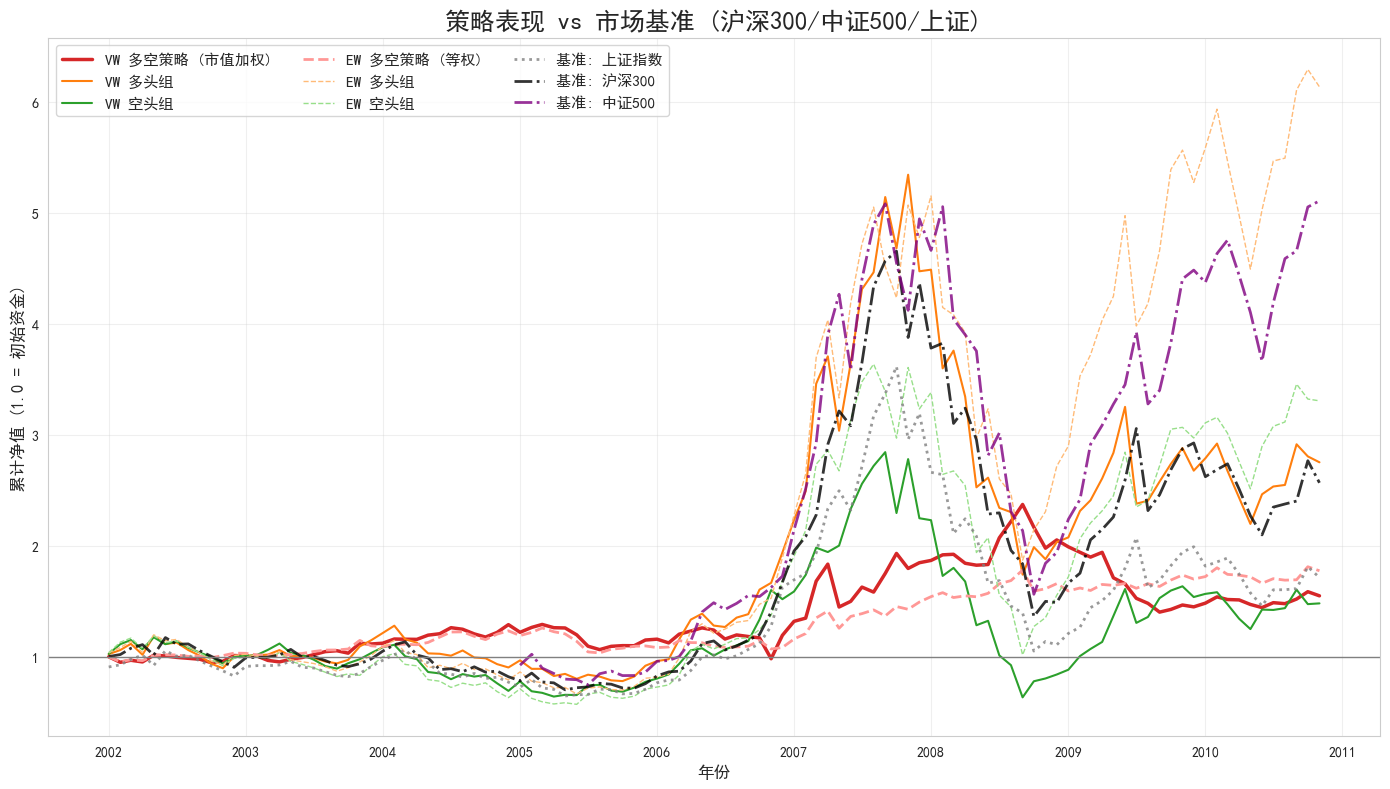

In [7]:
# ==========================================
# Step 5: 综合对比绘图 (EW vs VW)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 1. 计算累计净值
cum_performance = (1 + performance_df).cumprod()

# 2. 创建画布
plt.figure(figsize=(14, 8))

# --- 绘制市值加权 (VW) - 实线 ---
plt.plot(cum_performance.index, cum_performance['VW_Strategy'], 
         label='VW 多空策略 (市值加权)', color='#d62728', linewidth=2.5) # 深红
plt.plot(cum_performance.index, cum_performance['VW_Long'], 
         label='VW 多头组', color='#ff7f0e', linewidth=1.5) # 深橙
plt.plot(cum_performance.index, cum_performance['VW_Short'], 
         label='VW 空头组', color='#2ca02c', linewidth=1.5) # 深绿

# --- 绘制等权 (EW) - 虚线/透明度稍高 ---
# 既然都要在一张图，建议用同色系但不同线型来区分
plt.plot(cum_performance.index, cum_performance['EW_Strategy'], 
         label='EW 多空策略 (等权)', color='#ff9896', linestyle='--', linewidth=2) # 浅红
plt.plot(cum_performance.index, cum_performance['EW_Long'], 
         label='EW 多头组', color='#ffbb78', linestyle='--', linewidth=1) # 浅橙
plt.plot(cum_performance.index, cum_performance['EW_Short'], 
         label='EW 空头组', color='#98df8a', linestyle='--', linewidth=1) # 浅绿

# --- B. 绘制市场基准线 (新增部分) ---
if not cum_bench.empty:
    # 定义基准颜色和线型
    bench_styles = {
        '沪深300': {'color': 'black', 'linestyle': '-.'},
        '中证500': {'color': 'purple', 'linestyle': '-.'},
        '上证指数': {'color': 'gray', 'linestyle': ':'}
    }
    
    for col in cum_bench.columns:
        # 只画非空数据 (自动处理起始时间不同的问题)
        series = cum_bench[col].dropna()
        if not series.empty:
            style = bench_styles.get(col, {'color': 'blue', 'linestyle': '--'})
            plt.plot(series.index, series, 
                     label=f'基准: {col}', 
                     color=style['color'], 
                     linestyle=style['linestyle'], 
                     linewidth=2, 
                     alpha=0.8)

# 4. 辅助线和修饰
plt.axhline(y=1, color='grey', linestyle='-', linewidth=1)
plt.title('策略表现 vs 市场基准 (沪深300/中证500/上证)', fontsize=18, fontweight='bold')
plt.xlabel('年份', fontsize=12)
plt.ylabel('累计净值 (1.0 = 初始资金)', fontsize=12)

# 放置图例
plt.legend(fontsize=11, loc='upper left', ncol=3, frameon=True, fancybox=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()